<a href="https://colab.research.google.com/github/ekalafatic/MelanoMolesSmart/blob/master/RedesTorchVision.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy

plt.ion()   # interactive mode

#red = "resnet18"
#red = "resnet152"
#red = "googlenet"
#red = "alexnet"
#red = "vgg11"
#red = "vgg16"
#red = "squeezenet"
#red = "densenet"
#red = "mobilenet_v3_small"
#red = "mobilenet_v3_large"
#red = "efficientnet_b0"
red = "efficientnet_b7"

In [ ]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    epoch_loss = 0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
                torch.save(model.state_dict(), "./best.pth")

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model , time_elapsed , epoch_loss


In [ ]:
def visualize_model(model, grupo = 'val', num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders[grupo]):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('predicted: {}'.format(class_names[preds[j]]))
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

In [ ]:
# Clonar Dataset de Melanomas
!git clone https://github.com/NicoGiuliano/Melanomas2

Cloning into 'Melanomas2'...
remote: Enumerating objects: 1902, done.
remote: Counting objects: 100% (189/189), done.
remote: Compressing objects: 100% (189/189), done.
remote: Total 1902 (delta 0), reused 189 (delta 0), pack-reused 1713
Receiving objects: 100% (1902/1902), 1.31 GiB | 31.28 MiB/s, done.
Checking out files: 100% (2000/2000), done.


In [ ]:
# Data augmentation and normalization for training
# Just normalization for validation
image_size = 400

data_transforms = {
    'train': transforms.Compose([
        #transforms.RandomResizedCrop(224),
        #transforms.RandomHorizontalFlip(),
        #transforms.Resize(224),
        transforms.Resize((image_size,image_size)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        #transforms.Resize(256),
        transforms.Resize((image_size,image_size)),
        #transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        #transforms.Resize(256),
        transforms.Resize((image_size,image_size)),
        #transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

data_dir = '/content/Melanomas2'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val', 'test']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4, # VOLVER A 4
                                             shuffle=True, num_workers=2) # estaba en 4 pero se lo baje xq puede dar error 
              for x in ['train', 'val', 'test']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val', 'test']}
class_names = image_datasets['train'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [ ]:
data_dir = '/content/Melanomas2'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val', 'test']}
dataloaders2 = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=1, # VOLVER A 4
                                             shuffle=True, num_workers=2) # estaba en 4 pero se lo baje xq puede dar error 
              for x in ['train', 'val', 'test']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val', 'test']}
class_names = image_datasets['train'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

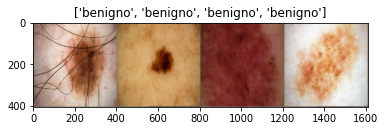

In [ ]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

In [ ]:
#funcion adicional para la de abajo
def set_parameter_requires_grad(model, feature_extracting):
    if feature_extracting:
        for param in model.parameters():
            param.requires_grad = False

#function para inicalizar diferentes modelos, adaptada para cada ARQUITECTURA
#sacado de https://pytorch.org/tutorials/beginner/finetuning_torchvision_models_tutorial.html
def initialize_model(model_name, num_classes, feature_extract, use_pretrained=True):
    # Initialize these variables which will be set in this if statement. Each of these
    #   variables is model specific.
    model_ft = None
    input_size = 0

    if model_name == "resnet18":
        """ Resnet18
        """
        model_ft = models.resnet18(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.fc.in_features
        model_ft.fc = nn.Linear(num_ftrs, num_classes)
        input_size = image_size

    elif model_name == "resnet152":
        """ Resnet152
        """
        model_ft = models.resnet152(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.fc.in_features
        model_ft.fc = nn.Linear(num_ftrs, num_classes)
        input_size = image_size

    elif model_name == "googlenet":
        """ GoogleNet
        """
        model_ft = models.googlenet(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.fc.in_features
        model_ft.fc = nn.Linear(num_ftrs, num_classes)
        input_size = image_size
    
    elif model_name == "efficientnet_b0":
        """ Efficientnet b0
        """
        model_ft = models.efficientnet_b0(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.classifier[1].in_features
        model_ft.classifier[1] = nn.Linear(num_ftrs,num_classes)
        input_size = image_size

    elif model_name == "efficientnet_b7":
        """ Efficientnet b7
        """
        model_ft = models.efficientnet_b3(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.classifier[1].in_features
        model_ft.classifier[1] = nn.Linear(num_ftrs,num_classes)
        input_size = image_size

    elif model_name == "mobilenet_v3_small":
        """ MobileNet v3 Small
        """
        model_ft = models.mobilenet_v3_small(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.classifier[3].in_features
        model_ft.classifier[3] = nn.Linear(num_ftrs,num_classes)
        input_size = image_size
    
    elif model_name == "mobilenet_v3_large":
        """ MobileNet v3 Large
        """
        model_ft = models.mobilenet_v3_large(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.classifier[3].in_features
        model_ft.classifier[3] = nn.Linear(num_ftrs,num_classes)
        input_size = image_size

    elif model_name == "alexnet":
        """ Alexnet
        """
        model_ft = models.alexnet(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.classifier[6].in_features
        model_ft.classifier[6] = nn.Linear(num_ftrs,num_classes)
        input_size = image_size
        model_ft.classifier

    elif model_name == "vgg11":
        """ VGG11_bn
        """
        model_ft = models.vgg11_bn(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.classifier[6].in_features
        model_ft.classifier[6] = nn.Linear(num_ftrs,num_classes)
        input_size = image_size
    
    elif model_name == "vgg16":
        """ VGG16
        """
        model_ft = models.vgg16(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.classifier[6].in_features
        model_ft.classifier[6] = nn.Linear(num_ftrs,num_classes)
        input_size = image_size

    elif model_name == "squeezenet":
        """ Squeezenet
        """
        model_ft = models.squeezenet1_0(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        model_ft.classifier[1] = nn.Conv2d(512, num_classes, kernel_size=(1,1), stride=(1,1))
        model_ft.num_classes = num_classes
        input_size = image_size

    elif model_name == "densenet":
        """ Densenet
        """
        model_ft = models.densenet121(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.classifier.in_features
        model_ft.classifier = nn.Linear(num_ftrs, num_classes)
        input_size = image_size

    else:
        print("Invalid model name, exiting...")
        exit()

    return model_ft, input_size

In [ ]:
#CARGO MODELO DE ARQUITECTURA

#model_ft, input_size = initialize_model(red, 2, False, use_pretrained=True)

# Print the model we just instantiated
#print(model_ft)

In [ ]:
# Modificando la linea que sigue se puede cambiar de red por cualquiera del sigueinte link:
# https://pytorch.org/vision/stable/models.html


#device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
#model_ft = model_ft.to(device)

#criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
#optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
#exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

In [ ]:
#torch.cuda.empty_cache()

In [ ]:
#model_ft, _ , _ = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=2)

In [ ]:
#visualize_model(model_ft, 'val')

#Test

In [ ]:
def test_model(model, grupo = 'val',):
    Prob = []
    Labels = []
    Predict = []
    List1 = []
    List2 = []
    m = nn.Softmax(dim=1)

    correct, total = 0 , 0

    with torch.no_grad():
        for i, (inputs, targets) in enumerate(dataloaders2[grupo]):

            inputs, targets = inputs.cuda(), targets.cuda()
            
            outputs = model(inputs)

            #print("out: ", outputs)
            prob1 =  m(outputs)[0][0].item()
            prob2 =  m(outputs)[0][1].item()
            #print("o1: ", o1, " -  o2: ", o2)
        
            # Set total and correct
            algo , predicted = torch.max(outputs.data, 1)
            #print("algo:", algo)
            #print("out data:", outputs.data)
            total += targets.size(0)
            #print("iteracion: ", i)
            #print("pred: ", predicted)
            #print("targ: ", targets) 
            #print("resultado: ", (predicted == targets).sum().item())
            #print("")
            correct += (predicted == targets).sum().item()

            #print(inputs)
            #print("------------------------------------------------------------")
            
            Labels.append(targets.item())
            Prob.append(prob2)


        # Print accuracy
        Ac = (100 * correct / total)
        print('Accuracy: %d %%' % Ac)
        

    return Labels, Prob , Ac
        

In [ ]:
#labels, prob, ac = test_model(model_ft, 'test')

In [ ]:
#prob

In [ ]:
#predict

In [ ]:
#labels

#Cálculo del Brier Score

In [ ]:
#https://scikit-learn.org/stable/modules/generated/sklearn.metrics.brier_score_loss.html

import matplotlib.pyplot as plt
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.calibration import CalibrationDisplay
from sklearn.metrics import brier_score_loss

#disp = CalibrationDisplay.from_predictions(labels, prob, n_bins=10)
#bs = brier_score_loss(labels, prob)
#bs = (int(bs * 10000))/10000
#plt.title("Red: " + red + "   -   Brier Score: " + str(bs))
#plt.show()



----------------------- Procesando Modelo:  efficientnet_b7  ----------------------------------


Downloading: "https://download.pytorch.org/models/efficientnet_b3_rwightman-cf984f9c.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b3_rwightman-cf984f9c.pth


  0%|          | 0.00/47.2M [00:00<?, ?B/s]

RuntimeError: ignored

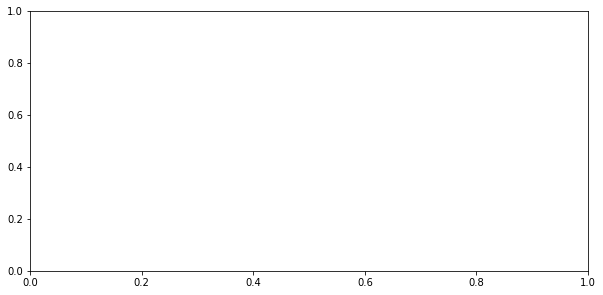

In [ ]:
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.calibration import CalibrationDisplay
from sklearn.metrics import brier_score_loss


fig = plt.figure(figsize=(10, 10))
gs = GridSpec(4, 2)
colors = plt.cm.get_cmap("Dark2")

ax_calibration_curve = fig.add_subplot(gs[:2, :2])
calibration_displays = {}

brier_scores = {}
accuracies = {}
losses = {}
times = {}

modelos1 = [ "resnet18", "resnet152", "vgg11", "vgg16" ]
modelos2 = [ "efficientnet_b7", "efficientnet_b0", "mobilenet_v3_small", "mobilenet_v3_large" ]
modelos3 = [ "googlenet", "alexnet", "squeezenet", "densenet" ]

modelos = modelos2

# Hiperparametros
learning_rate = 0.001
momentum = 0.9
step_size = 7 
gamma = 0.1
n_bins = 10
num_epochs = 10


for i, name in enumerate(modelos):
  print("----------------------- Procesando Modelo: ", name, " ----------------------------------" )
  #Def Model
  model_ft, input_size = initialize_model(name, 2, False, use_pretrained=True)

  # Cargar modelo a GPU
  device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
  model_ft = model_ft.to(device)

  #Def Hiperparametros
  criterion = nn.CrossEntropyLoss()

  # Observe that all parameters are being optimized
  optimizer_ft = optim.SGD(model_ft.parameters(), lr=learning_rate, momentum=momentum)
  print("parametros: ",model_ft.parameters())
  # Decay LR by a factor of 0.1 every 7 epochs
  exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=step_size, gamma=gamma)

  # Train model
  model_ft, tiempo , loss = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=num_epochs)
  times[name] = tiempo
  losses[name] = loss

  # Testeo  
  labels, prob, ac  = test_model(model_ft, 'test')
  accuracies[name] = ac
  
  # Calculo Brier Score
  bs = brier_score_loss(labels, prob)
  bs = (int(bs * 10000))/10000
  brier_scores[name] = bs

  # Plot
  display = CalibrationDisplay.from_predictions(labels, prob, n_bins=n_bins, name=name+" (bs: " + str(bs) + ")",
                                                ax=ax_calibration_curve, color=colors(i))
  calibration_displays[name] = display
  

ax_calibration_curve.grid()
ax_calibration_curve.set_title("Calibration plots")

# Add histogram
grid_positions = [(2, 0), (2, 1), (3, 0), (3, 1)]
for i, name in enumerate(modelos):
    row, col = grid_positions[i]
    ax = fig.add_subplot(gs[row, col])

    ax.hist(
        calibration_displays[name].y_prob,
        range=(0, 1),
        bins=n_bins,
        label=name,
        color=colors(i),
    )
    ax.set(title=name, xlabel="Mean predicted probability", ylabel="Count")

plt.tight_layout()
plt.show()

In [ ]:
brier_scores

In [ ]:
accuracies

In [ ]:
losses

In [ ]:
times 